### Задание

* Использовать dataset MovieLens
* Построить рекомендации (регрессия, предсказываем оценку) на фичах: 
    - TF-IDF на тегах и жанрах
    - Средние оценки (+ median, variance, etc.) пользователя и фильма
* Оценить RMSE на тестовой выборке

Предсказать (на выбор):
* Рейтинг фильма (жанр и релевантные содержанию теги) конкретного пользователя (профиль пользователя - по его тегам и оценкам других фильмов)
* Средний рейтинг фильма по жанру и релевантным его содержанию тегам

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

In [2]:
links = pd.read_csv('ml-latest/links.csv')

genome_scores = pd.read_csv('ml-latest/genome-scores.csv')
genome_tags = pd.read_csv('ml-latest/genome-tags.csv')

movies = pd.read_csv('ml-latest/movies.csv')
ratings = pd.read_csv('ml-latest/ratings.csv')
tags = pd.read_csv('ml-latest/tags.csv')

### Info
* ratings - в строке одна оценка (0.5-5) одного фильма одним пользователем
* tags - в строке один тег, к одному фильму одним пользователем
* movies - в строке один фильм, его название и жанр
* links - id фильмов в разных рейтинговых системах
* genome - данные о релевантности тегов обзорам фильма

In [3]:
# к ratings добавляем жанры фильма из movies
# tags собираем теги пользователя для каждого фильма
# к ratings (+жанры) добавляем по id пользователя его теги
# по genome_score отбираем релевантные теги для каждого фильма (movieId)
# объединяем релевантные теги для каждого фильма
# добавляем к ratings (+жанры +теги пользователя) по id фильма
# теги фильма, теги пользователя преобразуем TF-IDF
# можем взять средние оценки пользователя для фильмов разного жанра
# ищем сходство текстов
tags

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
...,...,...,...,...
1108992,283206,73017,fun,1264379059
1108993,283206,73017,homoerotic subtext,1264379058
1108994,283206,73017,pacing,1264379058
1108995,283206,73017,plot,1264379058


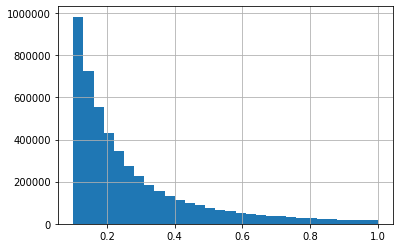

In [252]:
genome_scores.relevance[genome_scores.relevance > 0.1].hist(bins=30)

In [253]:
tags.sort_values('tag').head()

,userId,movieId,tag,timestamp
761894,164989,47950,!950's Superman TV show,1213794366
212949,60889,2890,!David O. Russell,1145118201
212950,60889,2890,!George Clooney,1145118181
212925,60889,260,!George Lucas,1145606306
106772,32875,4023,"""A Christmas Carol""",1457037403


In [254]:
genome_scores[genome_scores.movieId == 1].sort_values('relevance', ascending=False).head()

,movieId,tagId,relevance
1035,1,1036,0.99950
243,1,244,0.99900
785,1,786,0.99550
63,1,64,0.98875
588,1,589,0.98850


In [4]:
tags_with_movies = tags.join(movies.set_index('movieId'), on='movieId')
tags_with_movies

,userId,movieId,tag,timestamp,title,genres
0,14,110,epic,1443148538,Braveheart (1995),Action|Drama|War
1,14,110,Medieval,1443148532,Braveheart (1995),Action|Drama|War
2,14,260,sci-fi,1442169410,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
3,14,260,space action,1442169421,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
4,14,318,imdb top 250,1442615195,"Shawshank Redemption, The (1994)",Crime|Drama
...,...,...,...,...,...,...
1108992,283206,73017,fun,1264379059,Sherlock Holmes (2009),Action|Crime|Mystery|Thriller
1108993,283206,73017,homoerotic subtext,1264379058,Sherlock Holmes (2009),Action|Crime|Mystery|Thriller
1108994,283206,73017,pacing,1264379058,Sherlock Holmes (2009),Action|Crime|Mystery|Thriller
1108995,283206,73017,plot,1264379058,Sherlock Holmes (2009),Action|Crime|Mystery|Thriller


In [256]:
ratings

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


In [5]:
# уберем неревантные теги
best_scores = genome_scores[genome_scores.relevance > 0.7]
best_scores

,movieId,tagId,relevance
28,1,29,0.90700
62,1,63,0.95500
63,1,64,0.98875
185,1,186,0.95850
192,1,193,0.80350
...,...,...,...
14862243,187595,844,0.70250
14862249,187595,850,0.70450
14862296,187595,897,0.75175
14862342,187595,943,0.76950


In [6]:
# добавим содержание тегов
best_tags = best_scores.join(genome_tags.set_index('tagId'), on='tagId')
best_tags

,movieId,tagId,relevance,tag
28,1,29,0.90700,adventure
62,1,63,0.95500,animated
63,1,64,0.98875,animation
185,1,186,0.95850,cartoon
192,1,193,0.80350,cgi
...,...,...,...,...
14862243,187595,844,0.70250,redemption
14862249,187595,850,0.70450,revenge
14862296,187595,897,0.75175,secrets
14862342,187595,943,0.76950,space opera


In [7]:
# соберем теги по фильмам
tag_strings = []
movies_ = []

for movie, group in tqdm_notebook(best_tags.groupby('movieId')):
    tag_strings.append(' '.join([str(s).replace(' ', '').replace('-', '') for s in group.tag.values]))
    movies_.append(movie)

best_tags = zip(movies_, tag_strings)
best_tags

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [8]:
best_tags = pd.DataFrame(best_tags, columns = ['movieId', 'best_tags']) 
best_tags

,movieId,best_tags
0,1,adventure animated animation cartoon cgi child...
1,2,adventure animals basedonabook bigbudget child...
2,3,comedy goodsequel original romance sequel sequels
3,4,chickflick girliemovie romantic women
4,5,comedy family fatherdaughterrelationship feelg...
...,...,...
13143,185435,good malenudity notablenudity original pornogr...
13144,185585,original pg13
13145,186587,brutality dumbbutfunny family firstcontact hor...
13146,187593,absurd action antihero chase clever comedy dar...


In [9]:
# добавим список релевантных тегов к фильмам
movies_with_best_tags = movies.join(best_tags.set_index('movieId'), on='movieId')
movies_with_best_tags

,movieId,title,genres,best_tags
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,adventure animated animation cartoon cgi child...
1,2,Jumanji (1995),Adventure|Children|Fantasy,adventure animals basedonabook bigbudget child...
2,3,Grumpier Old Men (1995),Comedy|Romance,comedy goodsequel original romance sequel sequels
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,chickflick girliemovie romantic women
4,5,Father of the Bride Part II (1995),Comedy,comedy family fatherdaughterrelationship feelg...
...,...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed),NaN
58094,193878,Les tribulations d'une caissière (2011),Comedy,NaN
58095,193880,Her Name Was Mumu (2016),Drama,NaN
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi,NaN


In [10]:
# соберем теги к одному фильму по каждому пользователю
tag_strings = []
user_movies = []

for user_movie, group in tqdm_notebook(tags.groupby(['userId', 'movieId'])):
    tag_strings.append(' '.join([str(s).replace(' ', '').replace('-', '') for s in group.tag.values]))
    user_movies.append(user_movie)

list_tags = zip(user_movies, tag_strings)
list_tags = pd.DataFrame(list_tags, columns = ['user_movie', 'tags']) 
list_tags

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


,user_movie,tags
0,"(14, 110)",epic Medieval
1,"(14, 260)",scifi spaceaction
2,"(14, 318)",imdbtop250 justice
3,"(14, 480)",Dinosaurs
4,"(14, 593)",psychothriller
...,...,...
324365,"(283206, 71106)",fizzlesout friendship funny inconsistent timet...
324366,"(283206, 72407)",badacting badcgi kristenstewart sexismandstupi...
324367,"(283206, 72998)",effects raceissues
324368,"(283206, 73017)",costumes dialogue fun homoeroticsubtext pacing...


In [11]:
def func0(st):
    x = list(st)[0]

    return x

def func1(st):
    y = list(st)[1]

    return y

In [12]:
list_tags['movieId'] = list_tags.user_movie.apply(func1) 
list_tags['userId'] = list_tags.user_movie.apply(func0)
list_tags

,user_movie,tags,movieId,userId
0,"(14, 110)",epic Medieval,110,14
1,"(14, 260)",scifi spaceaction,260,14
2,"(14, 318)",imdbtop250 justice,318,14
3,"(14, 480)",Dinosaurs,480,14
4,"(14, 593)",psychothriller,593,14
...,...,...,...,...
324365,"(283206, 71106)",fizzlesout friendship funny inconsistent timet...,71106,283206
324366,"(283206, 72407)",badacting badcgi kristenstewart sexismandstupi...,72407,283206
324367,"(283206, 72998)",effects raceissues,72998,283206
324368,"(283206, 73017)",costumes dialogue fun homoeroticsubtext pacing...,73017,283206


In [13]:
# добавим в полученных list_tags информацию об рейтинге фильма
user_tags_rat = pd.merge(list_tags, ratings,  how='left', left_on=['userId','movieId'], right_on = ['userId','movieId'])
user_tags_rat

,user_movie,tags,movieId,userId,rating,timestamp
0,"(14, 110)",epic Medieval,110,14,4.5,1.442170e+09
1,"(14, 260)",scifi spaceaction,260,14,NaN,NaN
2,"(14, 318)",imdbtop250 justice,318,14,4.5,1.442169e+09
3,"(14, 480)",Dinosaurs,480,14,4.5,1.442169e+09
4,"(14, 593)",psychothriller,593,14,4.5,1.444009e+09
...,...,...,...,...,...,...
324365,"(283206, 71106)",fizzlesout friendship funny inconsistent timet...,71106,283206,3.5,1.264379e+09
324366,"(283206, 72407)",badacting badcgi kristenstewart sexismandstupi...,72407,283206,0.5,1.264379e+09
324367,"(283206, 72998)",effects raceissues,72998,283206,3.5,1.264378e+09
324368,"(283206, 73017)",costumes dialogue fun homoeroticsubtext pacing...,73017,283206,4.0,1.264379e+09


In [14]:
# осталось объединить с данными по фильмам и жанрам
user_tags_rat_movies = user_tags_rat.join(movies_with_best_tags.set_index('movieId'), on='movieId')
user_tags_rat_movies

,user_movie,tags,movieId,userId,rating,timestamp,title,genres,best_tags
0,"(14, 110)",epic Medieval,110,14,4.5,1.442170e+09,Braveheart (1995),Action|Drama|War,action actionpacked adventure amazingcinematog...
1,"(14, 260)",scifi spaceaction,260,14,NaN,NaN,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,70mm action adventure alien aliens androids aw...
2,"(14, 318)",imdbtop250 justice,318,14,4.5,1.442169e+09,"Shawshank Redemption, The (1994)",Crime|Drama,adaptation adaptedfrom:book atmospheric awesom...
3,"(14, 480)",Dinosaurs,480,14,4.5,1.442169e+09,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,action actionpacked adaptedfrom:book adventure...
4,"(14, 593)",psychothriller,593,14,4.5,1.444009e+09,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,adaptation adaptedfrom:book afi100(moviequotes...
...,...,...,...,...,...,...,...,...,...
324365,"(283206, 71106)",fizzlesout friendship funny inconsistent timet...,71106,283206,3.5,1.264379e+09,Frequently Asked Questions About Time Travel (...,Comedy|Sci-Fi,british britishcomedy cerebral clever comedy d...
324366,"(283206, 72407)",badacting badcgi kristenstewart sexismandstupi...,72407,283206,0.5,1.264379e+09,"Twilight Saga: New Moon, The (2009)",Drama|Fantasy|Horror|Romance|Thriller,adaptation adaptedfrom:book awesomesoundtrack ...
324367,"(283206, 72998)",effects raceissues,72998,283206,3.5,1.264378e+09,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,3d action alien aliens allegory beautifulscene...
324368,"(283206, 73017)",costumes dialogue fun homoeroticsubtext pacing...,73017,283206,4.0,1.264379e+09,Sherlock Holmes (2009),Action|Crime|Mystery|Thriller,action actionpacked adaptation adventure based...


In [15]:
# удаляем ненужные столбцы
del user_tags_rat_movies['timestamp']
del user_tags_rat_movies['user_movie']
user_tags_rat_movies

,tags,movieId,userId,rating,title,genres,best_tags
0,epic Medieval,110,14,4.5,Braveheart (1995),Action|Drama|War,action actionpacked adventure amazingcinematog...
1,scifi spaceaction,260,14,NaN,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,70mm action adventure alien aliens androids aw...
2,imdbtop250 justice,318,14,4.5,"Shawshank Redemption, The (1994)",Crime|Drama,adaptation adaptedfrom:book atmospheric awesom...
3,Dinosaurs,480,14,4.5,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,action actionpacked adaptedfrom:book adventure...
4,psychothriller,593,14,4.5,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,adaptation adaptedfrom:book afi100(moviequotes...
...,...,...,...,...,...,...,...
324365,fizzlesout friendship funny inconsistent timet...,71106,283206,3.5,Frequently Asked Questions About Time Travel (...,Comedy|Sci-Fi,british britishcomedy cerebral clever comedy d...
324366,badacting badcgi kristenstewart sexismandstupi...,72407,283206,0.5,"Twilight Saga: New Moon, The (2009)",Drama|Fantasy|Horror|Romance|Thriller,adaptation adaptedfrom:book awesomesoundtrack ...
324367,effects raceissues,72998,283206,3.5,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,3d action alien aliens allegory beautifulscene...
324368,costumes dialogue fun homoeroticsubtext pacing...,73017,283206,4.0,Sherlock Holmes (2009),Action|Crime|Mystery|Thriller,action actionpacked adaptation adventure based...


In [16]:
# удаляем NA
user_tags_rat_movies.dropna(inplace=True)
user_tags_rat_movies.head()

,tags,movieId,userId,rating,title,genres,best_tags
0,epic Medieval,110,14,4.5,Braveheart (1995),Action|Drama|War,action actionpacked adventure amazingcinematog...
2,imdbtop250 justice,318,14,4.5,"Shawshank Redemption, The (1994)",Crime|Drama,adaptation adaptedfrom:book atmospheric awesom...
3,Dinosaurs,480,14,4.5,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,action actionpacked adaptedfrom:book adventure...
4,psychothriller,593,14,4.5,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,adaptation adaptedfrom:book afi100(moviequotes...
5,philosophy surveillance,1682,14,4.0,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi,allegory aloneintheworld alternatereality cere...


In [17]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|'))

In [18]:
# очищаем данные по жанрам
user_tags_rat_movies['genres_new'] = user_tags_rat_movies.genres.apply(change_string)
#del user_tags_rat_movies['']
user_tags_rat_movies = user_tags_rat_movies[['userId', 'tags', 'movieId', 'title', 'genres_new', 'best_tags', 'rating']]

In [19]:
user_tags_rat_movies.head()

,userId,tags,movieId,title,genres_new,best_tags,rating
0,14,epic Medieval,110,Braveheart (1995),Action Drama War,action actionpacked adventure amazingcinematog...,4.5
2,14,imdbtop250 justice,318,"Shawshank Redemption, The (1994)",Crime Drama,adaptation adaptedfrom:book atmospheric awesom...,4.5
3,14,Dinosaurs,480,Jurassic Park (1993),Action Adventure SciFi Thriller,action actionpacked adaptedfrom:book adventure...,4.5
4,14,psychothriller,593,"Silence of the Lambs, The (1991)",Crime Horror Thriller,adaptation adaptedfrom:book afi100(moviequotes...,4.5
5,14,philosophy surveillance,1682,"Truman Show, The (1998)",Comedy Drama SciFi,allegory aloneintheworld alternatereality cere...,4.0


In [23]:
# объединяем теги пользователя данные о жанрах и лучшие теги фильма
user_tags_rat_movies['sum_'] = user_tags_rat_movies.tags + ' ' + user_tags_rat_movies.genres_new + ' ' + user_tags_rat_movies.best_tags
user_tags_rat_movies.head()

,userId,tags,movieId,title,genres_new,best_tags,rating,sum,sum_
0,14,epic Medieval,110,Braveheart (1995),Action Drama War,action actionpacked adventure amazingcinematog...,4.5,epic Medieval Action Drama War action actionpa...,epic Medieval Action Drama War action actionpa...
2,14,imdbtop250 justice,318,"Shawshank Redemption, The (1994)",Crime Drama,adaptation adaptedfrom:book atmospheric awesom...,4.5,imdbtop250 justice Crime Drama adaptation adap...,imdbtop250 justice Crime Drama adaptation adap...
3,14,Dinosaurs,480,Jurassic Park (1993),Action Adventure SciFi Thriller,action actionpacked adaptedfrom:book adventure...,4.5,Dinosaurs Action Adventure SciFi Thriller acti...,Dinosaurs Action Adventure SciFi Thriller acti...
4,14,psychothriller,593,"Silence of the Lambs, The (1991)",Crime Horror Thriller,adaptation adaptedfrom:book afi100(moviequotes...,4.5,psychothriller Crime Horror Thriller adaptatio...,psychothriller Crime Horror Thriller adaptatio...
5,14,philosophy surveillance,1682,"Truman Show, The (1998)",Comedy Drama SciFi,allegory aloneintheworld alternatereality cere...,4.0,philosophy surveillance Comedy Drama SciFi all...,philosophy surveillance Comedy Drama SciFi all...


In [25]:
#tags = user_tags_rat_movies.tags.values
#genres_new = user_tags_rat_movies.genres_new.values
#best_tags = user_tags_rat_movies.best_tags.values
sum_ = user_tags_rat_movies.sum_.values

In [26]:
def tfidf(X):
    count_vect = CountVectorizer()
    X_counts = count_vect.fit_transform(X)
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X_counts)
    
    return X_tfidf

In [27]:
# создаем tfidf матрицу 
#tags_tfidf = tfidf(tags)
#genres_new_tfidf = tfidf(genres_new)
#best_tags_tfidf = tfidf(best_tags)
sum_tfidf = tfidf(sum_)

#data = tags_tfidf.join(best_tags_tfidf)
#data_all = data.join(best_tags_tfidf)

In [30]:
y = user_tags_rat_movies.rating.values
#del user_tags_rat_movies['rating']

In [33]:
from sklearn.model_selection import train_test_split
X, testset, y, y_test = train_test_split(sum_tfidf, y, test_size=.3)

In [34]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X, y)
model.score(X, y)

0.45878068415768525

In [35]:
from sklearn.metrics import mean_squared_error

mean_squared_error(model.predict(testset), y_test, squared=False)

0.9892166382940147